In [1]:
# Numerical packages
import numpy as np
import pandas as pd 
from scipy.spatial.distance import cdist

# Graphing
import matplotlib.pyplot as plt
import plotly.express as px

# Clustering & PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.decomposition import PCA

# Machine Learning
import pycaret.classification as clf

### 1.0 Load Data

In [2]:
data = pd.read_pickle('data/marketing_dataset_cleaned.pkl')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Age,Total_Campaigns,Frequency,Monetary,PropWines,PropFruits,PropMeatProducts,PropFishProducts,PropSweetProducts,PropGoldProds
0,5524,1957,2,1,58138.0,0,0,2012-09-04,58,635,...,57,0,25,1617,0.392703,0.054422,0.337662,0.106370,0.054422,0.054422
1,2174,1954,2,1,46344.0,1,1,2014-03-08,38,11,...,60,0,6,27,0.407407,0.037037,0.222222,0.074074,0.037037,0.222222
2,4141,1965,2,2,71613.0,0,0,2013-08-21,26,426,...,49,0,21,776,0.548969,0.063144,0.163660,0.143041,0.027062,0.054124
3,6182,1984,2,2,26646.0,1,0,2014-02-10,26,11,...,30,0,8,53,0.207547,0.075472,0.377358,0.188679,0.056604,0.094340
4,5324,1981,4,2,58293.0,1,0,2014-01-19,94,173,...,33,0,19,422,0.409953,0.101896,0.279621,0.109005,0.063981,0.035545


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2212 non-null   int64         
 1   Year_Birth           2212 non-null   int64         
 2   Education            2212 non-null   int32         
 3   Marital_Status       2212 non-null   int32         
 4   Income               2212 non-null   float64       
 5   Kidhome              2212 non-null   int64         
 6   Teenhome             2212 non-null   int64         
 7   Dt_Customer          2212 non-null   datetime64[ns]
 8   Recency              2212 non-null   int64         
 9   MntWines             2212 non-null   int64         
 10  MntFruits            2212 non-null   int64         
 11  MntMeatProducts      2212 non-null   int64         
 12  MntFishProducts      2212 non-null   int64         
 13  MntSweetProducts     2212 non-null   i

The data has already been cleaned and pre-processed in a previous file.  

In [4]:
# Drop the columns that are not useful for clustering or are highly correlated with other columns in the dataset
data = data.drop(['ID', 'Dt_Customer', 'Year_Birth'], axis=1)

# Calculate the correlation matrix
corr_data = data.corr()
# Strip out the trivial diagonal values since the correlation value is between a  variable and itself
for x in range(len(data.columns)):
    corr_data.iloc[x,x] = 0.0
    
print(f"The maximum absolute correlation value is {corr_data.abs().max().max()}.")

The maximum absolute correlation value is 0.8929961009357751.


In [5]:
px.imshow(
    corr_data, 
    width=1000,
    height=1000,
    template='plotly_dark',
    title="Feature Correlations"
)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Education,2212.0,2.460669,1.004193,0.0,2.000000,2.000000,3.000000,4.000000
Marital_Status,2212.0,1.957505,0.675207,1.0,2.000000,2.000000,2.000000,4.000000
Income,2212.0,51958.810579,21527.278844,1730.0,35233.500000,51371.000000,68487.000000,162397.000000
Kidhome,2212.0,0.441682,0.536955,0.0,0.000000,0.000000,1.000000,2.000000
Teenhome,2212.0,0.505877,0.544253,0.0,0.000000,0.000000,1.000000,2.000000
Recency,2212.0,49.019439,28.943121,0.0,24.000000,49.000000,74.000000,99.000000
MntWines,2212.0,305.287523,337.322940,0.0,24.000000,175.500000,505.000000,1493.000000
MntFruits,2212.0,26.329566,39.744052,0.0,2.000000,8.000000,33.000000,199.000000
MntMeatProducts,2212.0,167.029837,224.254493,0.0,16.000000,68.000000,232.250000,1725.000000
MntFishProducts,2212.0,37.648734,54.772033,0.0,3.000000,12.000000,50.000000,259.000000


## 2.0 CLUSTERING FOR CUSTOMER SEGMENTATION
Note: all the columns in the dataset are numeric, and the dataset has only 2200 rows so no need for additional feature encoding or reducing the size for computation reasons
- 2.1 Apply a Standard Scaler for the data to be used later in feature reduction and a clustering algorithm
- 2.2 Find the optimal cluster size to apply the K-Means algorm
- 2.3 Apply the optimal K-Means algorithm to build a model
- 2.4 Apply a optimal clustering algorithm (K-means) after feature reduction (PCA)

In [7]:
# 2.1 Applying a Standards Scaler to the data
scaler = StandardScaler()

df = pd.DataFrame(
    scaler.fit_transform(data),
    columns=data.columns
)
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Education,2212.0,-4.175884e-17,1.000226,-2.450950,-0.458850,-0.458850,0.537201,1.533251
Marital_Status,2212.0,-5.139550e-17,1.000226,-1.418411,0.062951,0.062951,0.062951,3.025675
Income,2212.0,-1.252765e-16,1.000226,-2.333791,-0.777111,-0.027312,0.767952,5.131311
Kidhome,2212.0,4.175884e-17,1.000226,-0.822754,-0.822754,-0.822754,1.040021,2.902796
Teenhome,2212.0,9.636656e-17,1.000226,-0.929699,-0.929699,-0.929699,0.908097,2.745893
Recency,2212.0,4.015273e-18,1.000226,-1.694030,-0.864630,-0.000672,0.863287,1.727245
MntWines,2212.0,4.898633e-17,1.000226,-0.905235,-0.834071,-0.384844,0.592185,3.521791
MntFruits,2212.0,1.043971e-17,1.000226,-0.662628,-0.612295,-0.461294,0.167873,4.345543
MntMeatProducts,2212.0,3.212219e-18,1.000226,-0.744991,-0.673627,-0.441696,0.290897,6.948902
MntFishProducts,2212.0,-1.204582e-17,1.000226,-0.687527,-0.632742,-0.468387,0.225554,4.042233


#### 2.1 Keep track of the metrics for the different cluster sizes used to find the optimal cluster size

In [8]:
# Test k values from 1 to 10 clusters
max_k = 11
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
m = df.shape[0]
K = range(1, max_k)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
 
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / m)
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / m
    mapping2[k] = kmeanModel.inertia_

2.1 Plot the graphs of distortion and intertia by k to identify the optimal k values


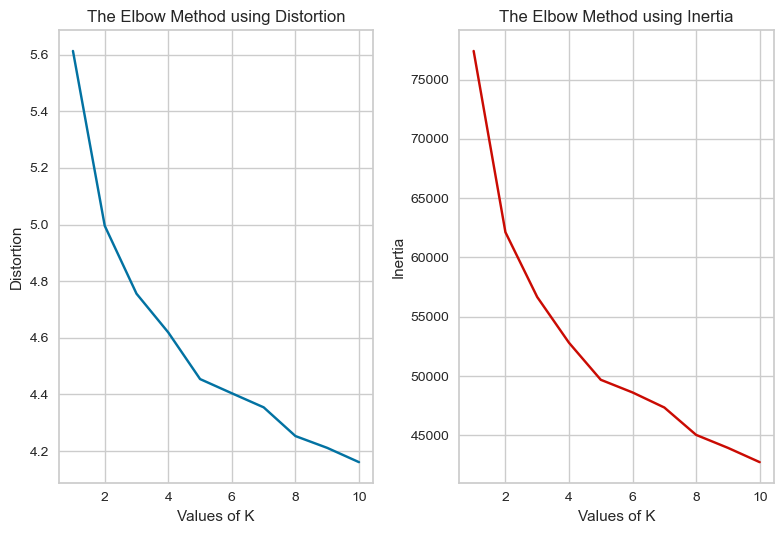

In [9]:
fig, axs = plt.subplots(1,2)
axs[0].plot(K, distortions, 'bx-')
axs[0].set_xlabel('Values of K')
axs[0].set_ylabel('Distortion')
axs[0].set_title('The Elbow Method using Distortion')

axs[1].plot(K, inertias, 'rx-')  # replace inertias with your list of inertia values
axs[1].set_xlabel('Values of K')
axs[1].set_ylabel('Inertia')
axs[1].set_title('The Elbow Method using Inertia')

plt.tight_layout()
plt.show()

In [10]:
inertias_diff = []
for i in range(1, len(inertias)):
    inertias_diff.append(inertias[i] - inertias[i-1]) 
    print(f"K={i+1} - K={i} = {inertias_diff[i-1]}")

K=2 - K=1 = -15287.156193334653
K=3 - K=2 = -5466.087490542937
K=4 - K=3 = -3858.589032152013
K=5 - K=4 = -3122.730304193952
K=6 - K=5 = -1068.6497527173706
K=7 - K=6 = -1270.8087509096658
K=8 - K=7 = -2309.6013751767387
K=9 - K=8 = -1092.5218072727948
K=10 - K=9 = -1207.0787622608623


#### 2.1 Insights: 
it looks like the decrease in inertia begins to slow between k values 4 and 5. So I'll choose k=4

In [11]:
model_kmeans_4 = KMeans(n_clusters=4, random_state = 357) 

model_kmeans_4.fit(df)
labels_4 = model_kmeans_4.labels_
df_kmeans = data.assign(label_4 = lambda x: pd.Categorical(labels_4))

In [12]:
model_kmeans_5 = KMeans(n_clusters=5, random_state = 357) 

model_kmeans_5.fit(df)
labels_5 = model_kmeans_5.labels_
df_kmeans = df_kmeans.assign(label_5 = lambda x: pd.Categorical(labels_5))

In [18]:
df_kmeans['label_5'].value_counts()

label_5
2    675
0    499
3    464
1    401
4    173
Name: count, dtype: int64

In [22]:
plot_kmeans_4 = px.scatter(
        df_kmeans, 
        x = 'Monetary',
        y = 'Income',
        color = "label_4",
        opacity=0.4,
        template="plotly_dark",
        title = "K-MEANS with 4 Clusters"
)
plot_kmeans_4.show()

In [23]:
plot_kmeans_5 = px.scatter(
        df_kmeans, 
        x = 'Monetary',
        y = 'Income',
        color = "label_5",
        opacity=0.4,
        template="plotly_dark",
        title = "K-MEANS with 5 clusters"
)
plot_kmeans_5.show()

### 2.1 KMenas Insights:
- The low income, low spend group can be segmented into two different clusters in both K-Means models.
- The high income, highest spend group can be segmented into two disctint groups (3,4) for K-Means with 5 clusters in comparison to the one group (3) for K-Means with 4 clusters. 
  
### 3.0 Apply Feature reduction (PCA) to segment clusters


In [25]:
# PCA
pca_model = PCA(n_components = 3, random_state =123)
pca_model.fit(df)
df_pca = pd.DataFrame(
        pca_model.transform(df),
        columns = ["PCA_1", "PCA_2", "PCA_3"]
)

In [27]:
# Plot
px.scatter_3d(
    df_pca.assign(label= lambda x: labels_4),
    x = "PCA_1",
    y = "PCA_2", 
    z = "PCA_3",
    color="label", 
    template = "plotly_dark",
    title = "PCA Space",
    width = 800, 
    height = 800
).update_traces(
    marker={
        'size':3,
        'line': {
            'width':1,
            'color':"white"
        }
    }
)

In [29]:
# Plot
px.scatter_3d(
    df_pca.assign(label5= lambda x: labels_5),
    x = "PCA_1",
    y = "PCA_2", 
    z = "PCA_3",
    color="label5", 
    template = "plotly_dark",
    title = "PCA Space",
    width = 800, 
    height = 800
).update_traces(
    marker={
        'size':3,
        'line': {
            'width':1,
            'color':"white"
        }
    }
)